In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
from numpy import nan
from constants import *
import sys
import warnings
import math
import os
import cftime
from glob import glob
from timeit import default_timer as timer # try to measure time
from CASutils import readdata_utils as read
from CASutils import calendar_utils as cal

In [2]:
# define functions
def read_cmip6(filepath,datestart,dateend):
    #open netcdf dataset
    dat = xr.open_mfdataset(filepath, coords="minimal", join="override", decode_times = True, use_cftime=True)  
    #convert calendar to standard, setting missing values as NaNs
    dat = dat.convert_calendar("standard", use_cftime=True, align_on="date",missing=np.nan)
    #interpolate the dataset using cftim_range
    dateidx = xr.cftime_range(datestart,dateend,freq='D',calendar="standard") 
    dat = dat.interp(time=dateidx,method="nearest") 
    #take slice
    dat = dat.sel(time=slice(datestart, dateend))
    dat = xr.decode_cf(dat, use_cftime = True) 
    return dat

#def read_field(filepath, datestart, dateend,latmin,latmax,plev):
#    """Read in a time slice from datestart to dateend and calculate the zonal mean.
#    Try using datetime64 and if that doesn't work decode times manually.
#    Args:
#        filepath (string) = path to files e.g., "/path/to/files/*.nc"
#        datestart (string) = start date for time slice
#        dateend (string) = end date for time slice
#    """
#
#    try:
#        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
#                 decode_times=True, use_cftime=True).\
#                 sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
#
#    except:
#                
#        print("Something's wierd about the time axis, decoding manually")
#        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
#                   decode_times=False)
#
#        dat=xr.decode_cf(dat, use_cftime=True)
#        dat=dat.sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
#        datetimeindex=dat.indexes['time'].to_datetimeindex()
#        dat['time'] = datetimeindex
#
#    return dat

def read_field(filepath, datestart, dateend,latmin,latmax,plev):
    """Read in a time slice from datestart to dateend and calculate the zonal mean.
    Try using datetime64 and if that doesn't work decode times manually.
    Args:
        filepath (string) = path to files e.g., "/path/to/files/*.nc"
        datestart (string) = start date for time slice
        dateend (string) = end date for time slice
    """

    try:
        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
                 decode_times=True, use_cftime=True)

    except:
                
        print("Something's wierd about the time axis, decoding manually")
        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
                   decode_times=False)

        dat=xr.decode_cf(dat, use_cftime=True)
        datetimeindex=dat.indexes['time'].to_datetimeindex()
        dat['time'] = datetimeindex
        
    dat=dat.sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
    return dat

def get_lat_lon_res(ds):
    '''Function to obtain the average lat and lon gridspacing from a dataset of a non regular model grid. '''
    lat = ds.coords['lat']
    lon = ds.coords['lon']
    difflat = lat - lat.shift(lat=1)
    latres = difflat.mean().to_numpy()
    difflon = lon - lon.shift(lon=1)
    lonres = difflon.mean().to_numpy()
    return latres, lonres

def def_domain(ncdf,min_lat,max_lat,min_lon,max_lon):
    LatIndexer, LonIndexer = 'lat', 'lon'
    ncdf = ncdf.loc[{LatIndexer: slice(min_lat, max_lat),
                      LonIndexer: slice(min_lon, max_lon)}]
    return ncdf

def norm_lon(ncdf):
    ncdf.coords['lon'] = (ncdf.coords['lon'] + 180) % 360 - 180
    return ncdf.sortby(ncdf.lon)

def get_ONDJFM_day(ncdf, months=[1,2,3,10,11,12],timedim="day"):
    return ncdf.isel({timedim:ncdf[timedim].dt.month.isin(months)})

In [3]:
os.chdir('/home/lseverino/MT/scripts')
importlib.reload(read)
importlib.reload(cal)
warnings.filterwarnings('ignore')


In [5]:
## constants
#paths
histpath="/net/atmos/data/cmip6/historical/"
ssp119path="/net/atmos/data/cmip6/ssp119/"
ssp126path="/net/atmos/data/cmip6/ssp126/"
ssp245path="/net/atmos/data/cmip6/ssp245/"
ssp370path="/net/atmos/data/cmip6/ssp370/"
ssp585path="/net/atmos/data/cmip6/ssp585/"

scenlist = ["historical","ssp126","ssp245","ssp370","ssp585"]
pathlist = [histpath,ssp126path,ssp245path,ssp370path,ssp585path]
pathdic = {"historical":histpath,"ssp126":ssp126path,"ssp245":ssp245path,"ssp370":ssp370path,"ssp585":ssp585path}
tres = "fx/"
var="orog"
pathout="../cmip6/"+var+'/'

cmip6models=pd.read_csv('../cmip6csvinfo/cmip6csvinfo_timeseries_ssp585_luca_daily.csv')




In [9]:
### constants
#select variable (cmip6 naming)
selvar = 'orog'
#dict for abbreviations of the cmip6 variables names
cmip6vars = {'sfcWindmax':'SWM','sfcWind':'SW','psl':'SLP','ua':'UA','orog':'OROG',}
##preprocessing and objects constants
gst_fact = 1.67
qt = 0.98
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["bg_rg"] #base resolution regridded
timeres = ["mon"]
domain = ["NH"]
#season = ["winE"]
#processings = ["qt98","gst1-67","cutarea0","cal1"]
sep = "_"
lst_bn = metvar+spaceres+domain
basenamemet = sep.join(lst_bn)
#lst_bn_proc = processings+metvar+spaceres+timeres+domain+season
#basenamemet_proc = sep.join(lst_bn_proc)





In [11]:
# get directories and member names
nmems_hist = dict()
#nmems_ssp119 = dict()
nmems_ssp126 = dict()
nmems_ssp245 = dict()
nmems_ssp370 = dict()
nmems_ssp585 = dict()
models_df = pd.DataFrame(columns=scenlist)
for ind,path in enumerate(pathlist):
    for subdir in os.scandir(path+tres+var):
        models_df.loc[subdir.name,scenlist[ind]] = len(os.listdir(subdir))
    
models_df.loc["total",:] = models_df.count(axis=0)

In [103]:
models_df.reindex(memname_df.index).

,historical,ssp126,ssp245,ssp370,ssp585
CanESM5,65,50,50,50,50
CNRM-CM6-1,30,NaN,NaN,3,NaN
CNRM-ESM2-1,8,NaN,NaN,3,NaN
EC-Earth3-Veg,NaN,NaN,NaN,NaN,NaN
EC-Earth3-Veg-LR,NaN,NaN,NaN,NaN,NaN
IPSL-CM6A-LR,32,3,5,10,1
MIROC-ES2L,31,10,30,10,10
UKESM1-0-LL,NaN,NaN,NaN,NaN,NaN
MRI-ESM2-0,12,5,10,5,6
FGOALS-g3,6,NaN,NaN,NaN,NaN


In [68]:
#select all models with minimum 3 members for the 5 scenarios
mods_3mem_allscen = models_df.where(models_df>=3).dropna(how='any').iloc[:-1,:]
mods_1mem_allscen = models_df.where(models_df>=1).dropna(how='any').iloc[:-1,:]
mods_1mem_hist_ssp585= models_df[["historical","ssp585"]].where(models_df>=1).dropna(how='any').iloc[:-1,:]
mods_1mem_hist = models_df[["historical"]].where(models_df>=1).dropna(how='any').iloc[:-1,:]


In [16]:
mods_1mem_hist_ssp585.drop(index=mods_3mem_allscen.index)

,historical,ssp585
CESM2-WACCM,3,5
GFDL-CM4,1,1
IPSL-CM6A-LR,32,1
NorESM2-LM,3,1
GFDL-ESM4,1,1
MPI-ESM1-2-HR,10,2
INM-CM4-8,1,1
E3SM-1-1,1,1
NorESM2-MM,3,1
TaiESM1,2,1


In [17]:
models_diff = pd.DataFrame()
for scen in scenlist[1:]:
    colname =  scen+" - hist"
    models_diff.loc[:,colname] = abs(models_df.loc[::-1,scen]-models_df.loc[::-1,"historical"])

In [18]:
# get populate dict with model names and member names
# force to get the same members as for sfcWindmax
varSWM = 'sfcWindmax'
tresSWM = 'day/'
dicscen = dict()
for ind,scen in enumerate(scenlist):
    path = pathlist[ind]
    dicscen[scen] = dict()
    for subdir in os.scandir(path+tresSWM+varSWM):
        #models_rcp85[subdir.name]=[]
        dicscen[scen][subdir.name] = [len(os.listdir(subdir))]
        dicscen[scen][subdir.name].append(os.listdir(subdir))
nmems_hist = dicscen['historical']
nmems_ssp585 = dicscen['ssp585']

In [19]:
# turn dicts into pd DataFrames because more convenient
nmems_hist_df = pd.DataFrame(nmems_hist, index=["hist","memnames"])
nmems_ssp585_df = pd.DataFrame(nmems_ssp585, index=["ssp585","memnames"])

In [20]:
# get common models that are both in historical and rcp85
nmems_hist_com = nmems_hist_df.reindex(nmems_ssp585_df.columns,axis=1).dropna(axis=1)
nmems_ssp585_com = nmems_ssp585_df.reindex(nmems_hist_df.columns,axis=1).dropna(axis=1)

In [21]:
#consider ONJDFM: start in D, finishes in M, adjust to have same number of days in both periods
ybegp = 1980 ; monbegp = 10 ; yendp = 2010 ; monendp = 3 ; daybegp = 1 ; dayendp = 30# dates for Past period, only takes 30th 
#ybegf = 2070 ; monbegf = 1 ; yendf = 2099 ; monendf = 12 ; daybegf = 1 ; dayendf = 31# dates for Future period
ybegf = 2070 ; monbegf = 10 ; yendf = 2100 ; monendf = 3 ; daybegf = 1 ; dayendf = 30# otherwise dont have the same length

# total number of months (used for checking)
nmonthsp = (yendp-ybegp-1)*12 + (12-monbegp+1) + monendp
nmonthsf = (yendf-ybegf-1)*12 + (12-monbegf+1) + monendf

# set up date names
dateformat ='%Y-%m-%d'

datebegp=str(ybegp)+"-"+str(monbegp).zfill(2)+"-"+str(daybegp).zfill(2)
dateendp=str(yendp)+"-"+str(monendp).zfill(2)+"-"+str(dayendp).zfill(2)
datebegf=str(ybegf)+"-"+str(monbegf).zfill(2)+"-"+str(daybegf).zfill(2)
dateendf=str(yendf)+"-"+str(monendf).zfill(2)+"-"+str(dayendf).zfill(2)

#set up daterange indexes
#daysidp = pd.date_range(datebegp,dateendp,freq='D')
#daysidf = pd.date_range(datebegf,dateendf,freq='D')

daysidp = xr.cftime_range(datebegp,dateendp,freq='D',calendar='standard')
daysidf = xr.cftime_range(datebegf,dateendf,freq='D',calendar='standard')

#nb of days
ndaysp = len(daysidp)
ndaysf = len(daysidf)

dayrangep = np.arange(1,ndaysp+1,1)
dayrangef = np.arange(1,ndaysf+1,1)

latout=np.linspace(-90,90,73)
lonout=np.linspace(0,357.5,144)
#lonout=np.linspace(0,360,144) # try to remove issues at border

# plevuse=[100000,92500,85000,70000,60000,50000,40000,30000,25000,20000,15000,10000,
#        7000,5000,3000,2000,1000]
# plevuse=[1000]



In [81]:
## select models
#try with models that have at least 3 members per scenario
modlist_3mem = mods_3mem_allscen.index.tolist()
modlist_1mem_sel = mods_1mem_hist.reindex(modlist_allscen+modlist_ssp585).dropna()
#modlist_1mem_sel = modlist_1mem_sel.drop(index=['HadGEM3-GC31-MM','HadGEM3-GC31-LL'])
modlist = modlist_1mem_sel.index.tolist()
#model_dl = []
#modlist = [mod for mod in modlist if mod not in model_dl]
for model in modlist:
    print("Members, historical: "+str(nmems_hist[model][0])+"\nMembers, rcp85: ",str(dicscen['ssp585'][model][0]))
models = pd.Series(modlist)

Members, historical: 50
Members, rcp85:  50
Members, historical: 30
Members, rcp85:  6
Members, historical: 10
Members, rcp85:  5
Members, historical: 33
Members, rcp85:  7
Members, historical: 31
Members, rcp85:  10
Members, historical: 12
Members, rcp85:  6
Members, historical: 5
Members, rcp85:  4
Members, historical: 40
Members, rcp85:  40
Members, historical: 50
Members, rcp85:  50
Members, historical: 30
Members, rcp85:  30
Members, historical: 5
Members, rcp85:  1
Members, historical: 1
Members, rcp85:  1
Members, historical: 1
Members, rcp85:  1
Members, historical: 11
Members, rcp85:  1
Members, historical: 1
Members, rcp85:  1
Members, historical: 10
Members, rcp85:  2
Members, historical: 1
Members, rcp85:  1
Members, historical: 10
Members, rcp85:  1
Members, historical: 2
Members, rcp85:  2


In [83]:
##select scenarios
selscen = ["historical"]
var ="orog"
tres = "fx/"

regrid = False
latrg = 2.5
lonrg = 2.5
#define domain
min_lat,max_lat = 0,90
min_lon,max_lon = 0,357.5
#nmems_hist = dicscen['historical']
#nmems_fut = dicscen['ssp585']
#select maximum of members to use 
nmem_max = 3
itercols = [selscen,range(nmem_max)]
col_idx= pd.MultiIndex.from_product(itercols,names=["scen","imem"])
#get member names
memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)

In [108]:
##load orog, rg rg
nmods = len(models)
modout=np.arange(0,nmods)

for index, modname in models.iteritems():
    start_time = timer()
    nmemsmin = nmem_max - memname_df.loc[modname].isna().sum()
    nmems = min((nmemsmin,nmem_max))
    #nmems=1
    memlistp = nmems_hist[modname][1]
    #get model resolution

    
    for scen in selscen:    
           #----sort out the future----
            nmems_dic = dicscen[scen]
            #memlist = nmems_dic[modname][1]
            scenpath = pathdic[scen]
            #nmemsf = nmems_dic[modname][0]
            memout=np.arange(0,nmems)
            meminit = True
            for imem in range(nmems):
                
                #memname = str(memlist[imem])
                memname = memname_df.loc[modname,(scen,str(imem))]
                print("Processing "+scen+" for "+modname+" "+memname+"...")
                
                scendir = glob(scenpath+tres+var+"/"+modname+"/"+memname+"/*/")
                try:
                    scendir = scendir[0]
                except:
                    print("break!")
                    break
                
                dat = xr.open_mfdataset(scendir+"*.nc", coords="minimal", join="override",
                                  decode_times=True, use_cftime=True).sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon))
                utemp = dat[var]
                #initiate array if first member
                if imem==0:
                    #get lat, lon, latres and lonres
                    lat = utemp.lat
                    lon = utemp.lon
                    min_lat=lat[0].to_numpy()
                    max_lat=lat[-1].to_numpy()
                    min_lon=lon[0].to_numpy()
                    max_lon=lon[-1].to_numpy()
                    latres, lonres = get_lat_lon_res(utemp)
                    if regrid:
                        latres = latrg
                        lonres = lonrg
                    else:
                        latres = latres.round(4)
                        lonres = lonres.round(4)
                    
                    latout = np.arange(min_lat,max_lat,latres)
                    lonout = np.arange(min_lon,max_lon,lonres)
            
                    uzmem = xr.DataArray(np.zeros([latout.size, lonout.size, nmems]), 
                                          coords=[latout, lonout, memout],dims=['lat','lon','member'], name=scen)
                
                utemp = dat[var]
                uinterp = utemp.interp(lat=latout,lon=lonout, method='linear',kwargs={"fill_value": None})
        
                uzmem.loc[dict(member=imem)]=uinterp
        
        
            # normalize longitude
            uzmemn = norm_lon(uzmem)
            
            
            #interpolate nans at 0deg longitude
            if np.any(np.isnan(uzmemn)):
                print('interpolating nans...')
                uzmemn = uzmemn.interpolate_na(dim="lon", method="linear")
            
            #save to netcdf
            
            #try:# see if file exist and merge to it
            #    #datain = xr.open_dataset(pathout+modname+'_'+basenamemet+".nc")
            #    #merged = xr.merge([datain,Usfc_EU_win])
            #    #merged.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc",mode="a",engine="scipy")
            #    uzmemn.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc",mode="a")
            #except: #otherwise directly create the file
            #    #Usfc_EU_win.to_netcdf(path=pathout+modname+'_'+basenamemet+"_allscens"+".nc",engine="scipy")
            #    uzmemn.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc")
                          
        
            time_delta_fut = timer() - start_time
            print(time_delta_fut)


Processing historical for CanESM5 r10i1p1f1...
Processing historical for CanESM5 r10i1p2f1...
Processing historical for CanESM5 r11i1p1f1...
0.20682818815112114
Processing historical for CNRM-CM6-1 r10i1p1f2...
Processing historical for CNRM-CM6-1 r1i1p1f2...
Processing historical for CNRM-CM6-1 r2i1p1f2...
0.2752424627542496
Processing historical for CNRM-ESM2-1 r1i1p1f2...
break!
0.0030669085681438446
Processing historical for IPSL-CM6A-LR r10i1p1f1...
Processing historical for IPSL-CM6A-LR r11i1p1f1...
Processing historical for IPSL-CM6A-LR r12i1p1f1...
0.22253983281552792
Processing historical for MIROC-ES2L r1i1000p1f2...
Processing historical for MIROC-ES2L r13i1p1f2...
Processing historical for MIROC-ES2L r11i1p1f2...
0.277609845623374
Processing historical for MRI-ESM2-0 r1i1p1f1...
Processing historical for MRI-ESM2-0 r2i1p1f1...
Processing historical for MRI-ESM2-0 r3i1p1f1...
0.2807490173727274
Processing historical for FGOALS-g3 r1i1p1f1...
Processing historical for FGOALS-

In [87]:
scenpath+tres+var+"/"+modname+"/"+memname+"/*/"

'/net/atmos/data/cmip6/historical/fx/orog/CNRM-ESM2-1/r1i1p1f2/*/'

In [82]:
with Usfc_EU_win as ds:
    datain = xr.open_dataset(pathout+modname+'_'+basenamemet+".nc")
    merged = xr.merge([datain,ds])
    print(merged)

<xarray.DataArray 'ssp585' (day: 5459, lat: 16, lon: 21, member: 3)>
[5502672 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 32.08 34.87 37.65 40.44 ... 65.55 68.34 71.13 73.92
  * lon      (lon) float64 -28.12 -25.31 -22.5 -19.69 ... 19.69 22.5 25.31 28.12
  * member   (member) int64 0 1 2
  * day      (day) int64 1 2 3 4 5 6 7 ... 10761 10762 10763 10764 10765 10766


In [104]:
datain = xr.open_dataset(pathout+modname+'_'+basenamemet+".nc")


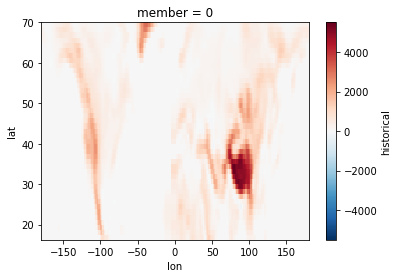

In [107]:
datain.historical.sel(member=0).plot()

uzmemf_mri = uzmemf
utemp_mri = utemp
uinterp_mri = uinterp